# Context


This notebook summarizes the steps in the development process for our survey model.

### The data

The model leverages a [public dataset](https://wwwn.cdc.gov/nchs/nhanes/default.aspx) from the National Health and Nutrition Examination Survey (NHANES). NHANES is a national survey that monitors the health and nutrional status of adults and children across the US. NHANCES is run by the National Center for Health Statistics (NCHS). NCHS is part of centers for disease control and prevention (CDC) and is responsible for producing vital and health statistics for the nation. The public database contains data to 40+ surveys that were each conducted 12 times between 1999-2020. 

### EDA & Data Pipeline

We explored roughly half of the survey files available in the database. For our final model we are using {XXX} different survey files spanning years of {YYY}. Our repository contains links to our jupyter notebooks used for creating our data-pipeline {ZZZ} & performing exploratory data analysis (EDA) {AAA}. 

### Model Development

#### Model Objective

The objective of our model is to predict whether a survey respondent is depressed. 
- The outcome variable is binary indicator variable called "MDD". The value is 1 if the individual has been diagnosed & is taking medication related to depression. 
- The input variables include data around demographic traits, medical & physical health, mood/behavioral data.

#### Training Phase

We explored several options during the training phase in an effort to build the best model and better understand our target sample.


1) We explored the following 6 classifiers for our model;
- Logistic Regression: XXX
- Random Forest: XXX
- Decision Tree: XXX
- K-Nearest Neighbor (KNN): XXX
- Naive Bayes: XXX
- Gradient Boosting Classifier: XXX

2) Positive class imbalance: Across our entire dataset ~4% of respondents have MDD=1. Among preganant woman, ~10% have MDD=1. We explored 3 stragies to account for this;
- SMOTE: XXX
- Test/Train Proportion: XXX
- Adding additional survey years: XXX
 
3) Segmentation: Our project is oriented around predicting PPD, hence our model focuses on predicting depression among woman that have been pregnant. We did however want to compare performance when across several groups; A) all respondents B) males only C) females only D) females that have been preganant only. This is used to understand potential differences in predicting depression among different audiences.

#### Test Phase



- Evaluation criteria: 
- Feature selection:
- Hyperparameters: 
- Error analysis:

# Model Development

## Setup

### Load Packages

In [25]:
# TODO: add annotations describing usage of different modules

from operator import mod
from os import getcwd
from os.path import exists, join

import joblib
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
# import xgboost as xgb
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

from sklearn.metrics import recall_score

from sklearn import tree
from sklearn.decomposition import PCA, SparsePCA

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image
import warnings

from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

import altair as alt
import random
import warnings

warnings.filterwarnings('ignore')

# set seaborn whitegrid theme
sns.set(style="whitegrid")

from sklearn.inspection import permutation_importance

### Load Data

In [118]:
cdc_survey = pd.read_csv('../data/cdc_nhanes_survey_responses_clean.csv')
print(cdc_survey.shape)

# filter to pregnant moms
cdc_survey_pmom = cdc_survey[cdc_survey['has_been_pregnant'] == 1]
print(cdc_survey_pmom.shape)

(35706, 863)
(7741, 863)


### Candidate Features

Here we list out all candidate features for our model. 

In [114]:
candidate_features = [
    # Depression screener
    'little_interest_in_doing_things',
    'feeling_down_depressed_hopeless',
    'trouble_falling_or_staying_asleep',
    'feeling_tired_or_having_little_energy',
    'poor_appetitie_or_overeating',
    'feeling_bad_about_yourself',
    'trouble_concentrating',
    'moving_or_speaking_to_slowly_or_fast',
    'thoughts_you_would_be_better_off_dead',
    'difficult_doing_daytoday_tasks',
    # Alcohol & smoking
    'has_smoked_tabacco_last_5days',
    'alcoholic_drinks_past_12mo', 
    'drank_alc',
    'alc_drinking_freq',
    'alc_per_day',
    'times_with_4or5_alc',
    'times_with_8plus_alc',
    'times_with_12plus_alc',
    '4plus_alc_daily',
    'days_4plus_drinks_occasion',
    #Blood Pressure & Cholesterol
    'high_bp',
    'age_hypertension',
    'hypertension_prescription',
    'high_bp_prescription',
    'high_cholesterol',
    'cholesterol_prescription',
    #Cardiovascular Health
    'chest_discomfort',
    # Diet & Nutrition
    'how_healthy_is_your_diet',    
    'count_lost_10plus_pounds',
    'has_tried_to_lose_weight_12mo', 
    #'breastfed',
    'milk_consumption_freq',
    'govmnt_meal_delivery',
    'nonhomemade_meals',
    'fastfood_meals',
    'readytoeat_meals',
    'frozen_pizza',
    #Food Security
    'emergency_food_received',
    'food_stamps_used',
    #'wic_benefit_used',
    #Hospital Utilization & Access to Care
    'general_health',
    'regular_healthcare_place',
    'time_since_last_healthcare',
    'overnight_in_hospital',
    'seen_mental_health_professional',
    #Health Insurance
    'have_health_insurance',
    'have_private_insurance',
    'plan_cover_prescriptions',
    #Income
    'family_poverty_level',
    'family_poverty_level_category',
    #Medical Conditions
    'asthma',
    'anemia_treatment',
    'blood_transfusion',
    'arthritis',
    'heart_failure',
    'coronary_heart_disease',
    'angina_pectoris',
    'heart_attack',
    'stroke',
    'thyroid_issues',
    'respiratory_issues',
    'abdominal_pain',
    'gallstones',
    'gallbladder_surgery',
    'cancer',
    'dr_recommend_lose_weight',
    'dr_recommend_exercise',
    'dr_recommend_reduce_salt',
    'dr_recommend_reduce_fat',
    'currently_losing_weight',
    'currently_increase_exercise',
    'currently_reducing_salt',
    'currently_reducing_fat',
    'metal_objects',
    #Occupation
    'hours_worked',
    'over_35_hrs_worked',
    'work_schedule',
    #Physical Activity
    'vigorous_work',
    'walk_or_bicycle',
    'vigorous_recreation',
    'moderate_recreation',
    # Physical health & Medical History
    'count_days_seen_doctor_12mo',
    'duration_last_healthcare_visit',        
    'count_days_moderate_recreational_activity',   
    'count_minutes_moderate_recreational_activity',
    'count_minutes_moderate_sedentary_activity',
    'general_health_condition',    
    'has_diabetes',
    'has_overweight_diagnosis',  
    #Reproductive Health
    'regular_periods',
    'age_last_period',
    'try_pregnancy_1yr',
    'see_dr_fertility',
    'pelvic_infection',
    'pregnant_now',
    'pregnancy_count',
    'diabetes_pregnancy',
    'delivery_count',
    'live_birth_count',
    'age_at_first_birth',
    'age_at_last_birth',
    'months_since_birth',
    'horomones_not_bc',
    #Smoking
    'smoked_100_cigs',
    'currently_smoke',
    #Weight History
    'height_in',
    'weight_lbs',
    'attempt_weight_loss_1yr',
    # Demographic data
    'food_security_level_household',   
    'food_security_level_adult',    
    'monthly_poverty_index_category',
    'monthly_poverty_index',
    'count_hours_worked_last_week',
    'age_in_years',   
    'education_level',
    'is_usa_born',    
    'has_health_insurance',
    'has_health_insurance_gap'   
]

dep_screener_cols = candidate_features[0:10] 
len(candidate_features)

116

### Function to create test & train dataset

In [115]:
def get_model_data(original_df, 
                   columns, 
                   test_size_prop=0.2,
                   drop_null_rows=False,
                   null_imputer_strategy='median', # mean, median, most_frequent
                   use_value_scaler=True,
                   use_smote=False):
    """
    Function to build feature & indicator matrices for both train & test.
    """
    
    # add target column (MDD)
    cols_to_use = columns.copy()
    cols_to_use.insert(0, 'MDD')
    
    df_to_use = original_df[cols_to_use]
    
    if drop_null_rows:
        df_to_use.dropna(inplace=True)
    
    # Create test & train data
    x = df_to_use.iloc[:,1:].values
    y = df_to_use['MDD'].values
    
    if not drop_null_rows:
        # SimpleImputer() = fill in missing values
        # note imputer may drop columns if no values exist for it
        imputer = SimpleImputer(strategy=null_imputer_strategy)  
        x = imputer.fit_transform(x)

    # RobustScaler() = scale features to remove outliers
    if use_value_scaler:
        trans = RobustScaler()
        x = trans.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(
        x, 
        y, 
        test_size=test_size_prop, 
        random_state=42
    ) 
    
    # Technique to de-risk from positive class imbalance
    if use_smote:
        sm = SMOTE(random_state=42)
        x_train, y_train = sm.fit_resample(x_train, y_train)
    
    return x_train, x_test, y_train, y_test

### Function to get performance across different models

In [5]:
def get_performance_df(label_actual, label_pred, model_name):
    """
    Function to calculate performance metrics for model.
    Includes precision, recal, F1, & support.
    """
    # create classification report
    result_table = classification_report(label_actual, label_pred, output_dict=True)
    result_table = pd.DataFrame.from_dict(result_table)

    # store for later
    accuracies = result_table['accuracy']

    # rename grouping
    result_table.columns = [
        'depressed_no',
        'depressed_yes',
        'accuracy',
        'macro_avg',
        'weighted_avg'
    ]

    # create dataframe with 1 row per grouping
    result_table.drop(labels = 'accuracy', axis = 1, inplace=True)
    result_table = result_table.transpose()
    result_table['accuracy'] = list(accuracies)
    result_table = result_table.reset_index()
    result_table.rename(columns = {'index':'grouping'},inplace=True)
    result_table['model'] = model_name
    result_table = result_table[['model','grouping','precision','recall','f1-score','support','accuracy']]
    return result_table

def generate_models(
    x_train, 
    y_train, 
    x_test, 
    y_test):
    """
    Function that trains and makes predictions using 5 of the classifiers went over during the class.
    Meant as a helper function for easier testing of different modeling pipelines.
    """

    # K-Nearest Neighbors
    knn = KNeighborsClassifier()
    knn.fit(x_train, y_train)
    pred_labels_knn  = knn.predict(x_test)
    score_knn = get_performance_df(y_test, pred_labels_knn,'Knn')
    
    # Logistic Regression
    lm = LogisticRegression()
    lm.fit(x_train, y_train)
    pred_labels_lr  = lm.predict(x_test)
    score_lr = get_performance_df(y_test, pred_labels_lr,'Logistic Regression')
        
    # Bernoulii Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(x_train, y_train)
    pred_labels_bnb  = bnb.predict(x_test)
    score_bnb = get_performance_df(y_test, pred_labels_bnb,'Bernoulli Naive Bayes')    
        
    # Gaussian Naive Bayes
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    pred_labels_gnb  = gnb.predict(x_test)
    score_gnb = get_performance_df(y_test, pred_labels_gnb,'Gaussian Naive Bayes')    

    # Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(x_train, y_train)
    pred_labels_rf  = rf.predict(x_test)
    predictions_posterior_rf = rf.predict_proba(x_test)
    score_rf = get_performance_df(y_test, pred_labels_rf,'Random Forest')   
    
    #Decision Tree
    dt = DecisionTreeClassifier()
    dt.fit(x_train, y_train)
    pred_labels_dt = dt.predict(x_test)
    score_dt = get_performance_df(y_test, pred_labels_dt,'Decision Tree')

    #Gradient Boosting Classifier
    gb = GradientBoostingClassifier()
    gb.fit(x_train, y_train)
    pred_labels_gb = gb.predict(x_test)
    score_gb = get_performance_df(y_test, pred_labels_gb,'Gradient Boosting Classifier')
    
    # make dataframe with scores
    scores = pd.concat([score_knn, score_lr, score_bnb, score_gnb, score_rf, score_dt, score_gb])
    scores = scores.sort_values(by = 'recall', ascending=False)

    # determine which groupings to include
    #if not show_all_groupings:
    #    scores = scores[scores['grouping'] == 'macro_avg']
        
    # make dataframe with predictions
    predictions = pd.DataFrame({
        'actuals':y_test,
        'pred_knn':pred_labels_knn,
        'pred_logistic_regression':pred_labels_lr,
        'pred_bernoulli_naive_bayes':pred_labels_bnb,
        'pred_gaussian_naive_bayes':pred_labels_gnb,
        'pred_random_forest':pred_labels_rf,
        'pred_decision_tree':pred_labels_dt,
        'pred_gradient_boosting_classifier':pred_labels_gb
    })

    return scores, predictions

### Function for Error analysis

In [6]:
def plot_confusion_matrix(y_test, pred_labels):
    """
    Function that displays a confusion matrix for provided true and predicted classes
    """
    #print(f'cover type 1 and type 2 total correct {np.sum(np.diag(metrics.confusion_matrix(y_test, pred_labels))[:2])}')

    cm = confusion_matrix(y_test, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5,5))
    disp = disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')    
    plt.grid(False)
    plt.show()
    return

def label_pred(row):
    """
    Function that labels prediction cases into TP, TN, FP, FN
    """
    if row['y_actual'] == row['y_pred']:
        if row['y_actual'] == 1:
            result = 'TP'
        else:
            result = 'TN'
    else: 
        if row['y_actual'] == 1:
            result = 'FN'
        else:
            result = 'FP'

    return result

def create_error_plots(
    y_actuals,
    y_predictions,
    x_test_matrix,
    x_test_columns,
    columns_to_plot,
    show_bar_plot=True,
    show_density_plot=True):
    """
    Function that creates bi-variate plots comparing TP, TN, FP, FN for each desired feature column.
    """
    
    ### Create dataframe of predictions & feature 
    
    # create dataframe with actuals & predictions w/ labels
    prediction_labels = pd.DataFrame(columns = ['y_actual','y_pred'])
    prediction_labels['y_actual'] = y_actuals
    prediction_labels['y_pred'] = y_predictions
    prediction_labels['label'] = prediction_labels.apply(label_pred, axis = 1)

    # feature df 
    feature_df = pd.DataFrame(x_test_matrix, columns = x_test_columns)

    # combine into 1
    pred_data = pd.concat([prediction_labels, feature_df], axis = 1)

    ### Bi-variate plots
    for column in columns_to_plot:
    
        if show_density_plot:
            ## Density plot
            sns.kdeplot(
                data=pred_data, 
                x=column, 
                hue="label", 
                cut=0, 
                common_norm=False, 
                alpha=0.4
            )

        if show_bar_plot:
            ## barplot
            # create % of total column by group
            group_data = pred_data.groupby(['label',column])['y_actual'].count().reset_index()
            group_data['Pct of Total'] = group_data['y_actual'] / group_data.groupby('label')['y_actual'].transform('sum')

            sns.catplot(
                data=group_data, 
                kind="bar",
                x=column, 
                y="Pct of Total", 
                hue="label",
                alpha = 0.8
            )

        plt.show()

## Baseline Model

We start by building baseline models across the 6 classifiers. We start by using the 10 questions from the depression screener questionaire.

In [119]:
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom,
    columns = dep_screener_cols
)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

baseline_model, predictions = generate_models(
    x_train, 
    y_train, 
    x_test, 
    y_test
)

(6192, 10)
(1549, 10)
(6192,)
(1549,)


In [120]:
baseline_model_summary = baseline_model[baseline_model['grouping'] == 'macro_avg']
baseline_model_summary[['model','recall','f1-score','precision','accuracy']]

,model,recall,f1-score,precision,accuracy
2,Bernoulli Naive Bayes,0.675232,0.632390,0.614506,0.826985
2,Gaussian Naive Bayes,0.660506,0.633699,0.618641,0.840542
2,Decision Tree,0.557301,0.567442,0.592593,0.870239
2,Random Forest,0.543840,0.555191,0.688099,0.896062
2,Logistic Regression,0.538270,0.546401,0.685605,0.896062
2,Knn,0.534046,0.539683,0.655004,0.893480
2,Gradient Boosting Classifier,0.519854,0.513698,0.719752,0.897999


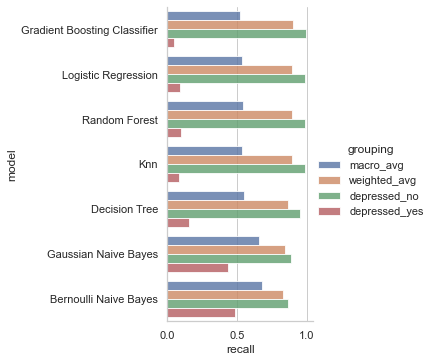

In [39]:
sns.catplot(
    data=baseline_model, 
    kind="bar",
    x='recall', 
    y="model", 
    hue="grouping",
    hue_order=['macro_avg','weighted_avg','depressed_no','depressed_yes'],
    alpha = 0.8
)

pass

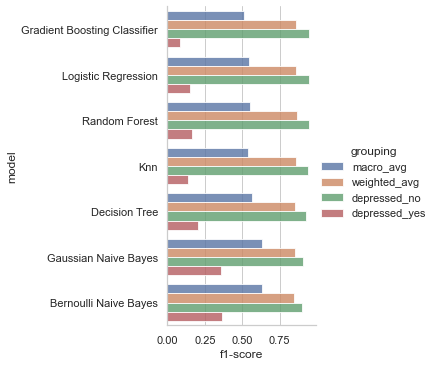

In [23]:
sns.catplot(
    data=baseline_model, 
    kind="bar",
    x='f1-score', 
    y="model", 
    hue="grouping",
    hue_order=['macro_avg','weighted_avg','depressed_no','depressed_yes'],
    alpha = 0.8
)

pass

## Error Analysis

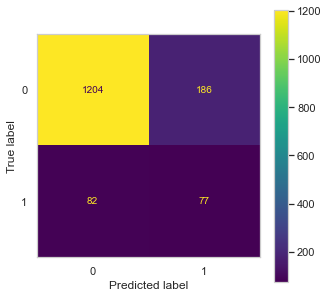

In [24]:
cm = confusion_matrix(predictions['actuals'], predictions['pred_bernoulli_naive_bayes'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5,5))
disp = disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')    
plt.grid(False)
plt.show()

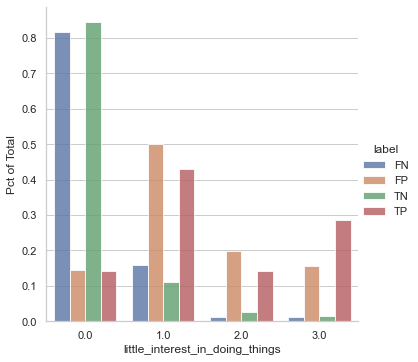

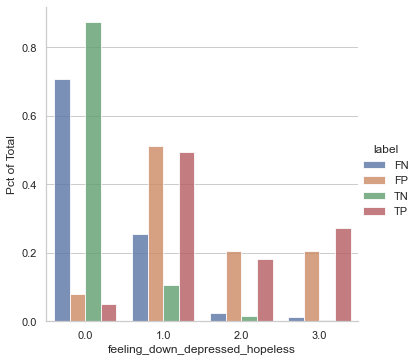

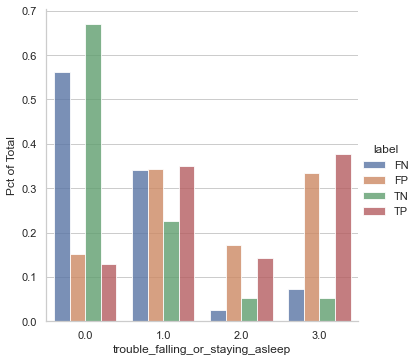

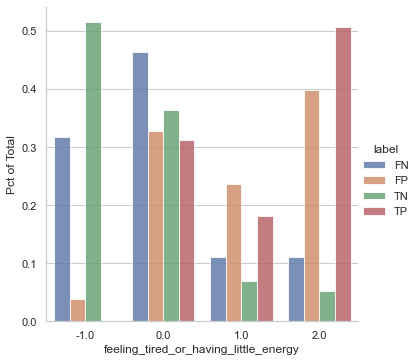

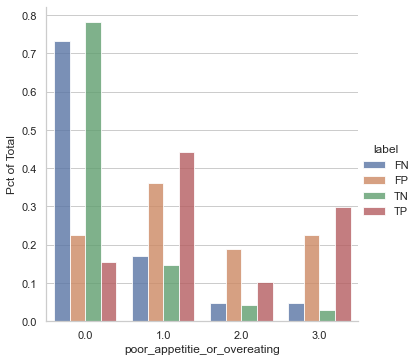

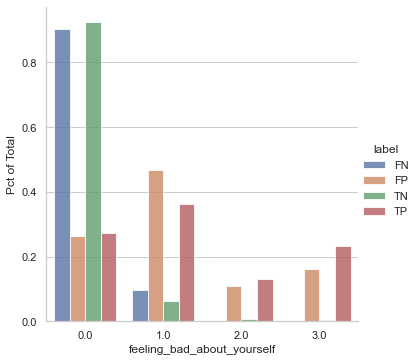

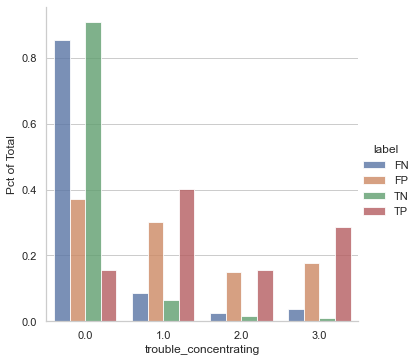

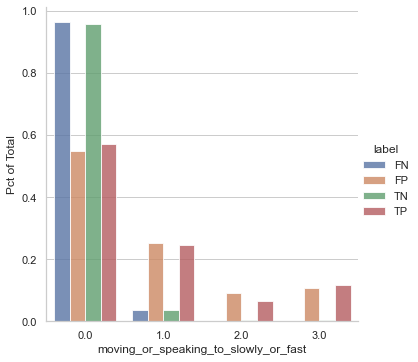

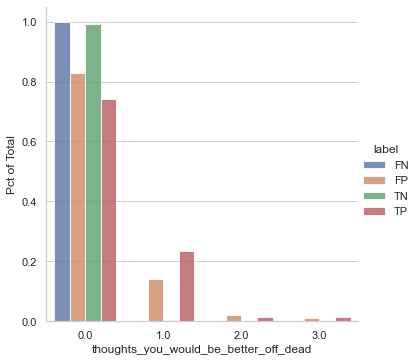

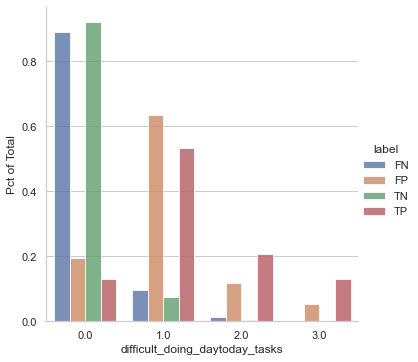

In [42]:
create_error_plots(
    y_actuals = predictions['actuals'],
    y_predictions = predictions['pred_bernoulli_naive_bayes'],
    x_test_matrix = x_test,
    x_test_columns = dep_screener_cols,
    columns_to_plot = dep_screener_cols,
    show_density_plot=False
)

## Feature Importance

In [121]:
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom,
    columns = candidate_features
)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

baseline_model, predictions = generate_models(
    x_train, 
    y_train, 
    x_test, 
    y_test
)

(6192, 116)
(1549, 116)
(6192,)
(1549,)


In [122]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(x_train, y_train)
perm_importance = permutation_importance(gnb, x_test, y_test, n_repeats=10,random_state=0)

In [104]:
len(candidate_features)

118

In [127]:
gnb_importances = pd.DataFrame({
    'feature':candidate_features,
    'importance_mean':perm_importance['importances_mean'],
    'importance_std':perm_importance['importances_std']
}).sort_values(by='importance_mean',ascending=False)
gnb_importances

,feature,importance_mean,importance_std
5,feeling_bad_about_yourself,0.007941,0.001043
9,difficult_doing_daytoday_tasks,0.005423,0.002164
8,thoughts_you_would_be_better_off_dead,0.004713,0.001894
55,heart_attack,0.003357,0.001798
71,metal_objects,0.003163,0.001171
...,...,...,...
40,time_since_last_healthcare,-0.002905,0.002728
80,duration_last_healthcare_visit,-0.002905,0.002728
59,abdominal_pain,-0.003228,0.001555
43,have_health_insurance,-0.003809,0.001273


In [80]:
def get_random_forest_n_top_features(train_data=x_train, 
                                     train_labels=y_train,
                                     feature_columns=dep_screener_cols):
    """
    A model that trains a random forest model and returns the feature importances as a dataframe.
    The index of the row corresponds to the column index in the initial array
    """
    
    # fit random forest and print accuracy
    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_data, train_labels)
   
    # list feature importances
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    feature_importances = pd.DataFrame({'Feature': feature_columns,'Coefficient': importances})
    feature_importances = feature_importances.sort_values('Coefficient',ascending=False)
    
    return feature_importances

In [81]:
get_random_forest_n_top_features()

,Feature,Coefficient
1,feeling_down_depressed_hopeless,0.116370
4,poor_appetitie_or_overeating,0.116036
2,trouble_falling_or_staying_asleep,0.113776
6,trouble_concentrating,0.107036
9,difficult_doing_daytoday_tasks,0.105663
0,little_interest_in_doing_things,0.105246
3,feeling_tired_or_having_little_energy,0.104398
5,feeling_bad_about_yourself,0.099671
7,moving_or_speaking_to_slowly_or_fast,0.088079
8,thoughts_you_would_be_better_off_dead,0.043725


In [90]:
cor_columns = candidate_features.copy()
cor_columns.append('MDD')
correlation_matrix = cdc_survey_pmom[cor_columns].corr(method='pearson')

correlation_values_abs = abs(correlation_matrix['MDD']).sort_values(ascending=False)
correlation_values_abs = correlation_values_abs[correlation_values_abs.notna()]

In [91]:
correlation_values_abs

MDD                                      1.000000
seen_mental_health_professional          0.281615
feeling_down_depressed_hopeless          0.266087
difficult_doing_daytoday_tasks           0.251297
feeling_tired_or_having_little_energy    0.225408
                                           ...   
diabetes_pregnancy                       0.006104
milk_consumption_freq                    0.004062
has_health_insurance_gap                 0.002609
days_4plus_drinks_occasion               0.001035
fastfood_meals                           0.000599
Name: MDD, Length: 116, dtype: float64

## Optimizations